# Explainable AI for Pneumonia Detection: Clinical Validation & Error Analysis

**Domain:** Computer Vision & Medical Imaging  
**Architecture:** ResNet-18 with Two-Stage Transfer Learning  
**Key Techniques:** Gradient-weighted Class Activation Mapping (Grad-CAM), Deep Failure Analysis  

---

## Project Objective
The goal of this project is to develop a highly sensitive diagnostic tool for detecting Pneumonia from Chest X-rays. In medical AI, missing a positive diagnosis (False Negative) carries severe clinical risks. Therefore, this pipeline is aggressively optimized for **Recall**, successfully achieving a **98% detection rate**.

## Why Explainability Matters (XAI)
Medical professionals cannot rely on "black box" algorithms. This notebook implements custom **Grad-CAM** hooks to visualize the specific feature maps that drive the model's predictions. By overlaying these activation heatmaps onto the original X-rays, we can clinically verify that the model is making decisions based on pulmonary opacities and infiltrates, rather than anatomical shortcuts or background artifacts.

## ⚙️ Methodology Overview
1. **Baseline Establishment:** Initial training of the classification head to establish a performance floor.
2. **Precision Fine-Tuning:** Unfreezing the entire network using a highly restricted learning rate ($1 \times 10^{-5}$) to adapt the deeper convolutional filters to X-ray specific textures without catastrophic forgetting.
3. **Edge Case Analysis:** A deep-dive investigation into the model's remaining False Negatives to identify architectural limitations and anatomical distractions.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val/test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def load_data(data_dir, batch_size=32):
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val/test']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val/test'])
    }

    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                  for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names


In [3]:
def load_data(data_dir, batch_size=32):

    #Loading datasets
    train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
    val_dataset   = datasets.ImageFolder(data_dir + '/val', transform=data_transforms['val/test'])
    test_dataset  = datasets.ImageFolder(data_dir + '/test', transform=data_transforms['val/test'])

    #Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #making it false for gradcam visualization
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Store in dictionary
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }

    #Dataset sizes
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    }

    #Class names
    class_names = train_dataset.classes

    return dataloaders, dataset_sizes, class_names

In [4]:
import os
import zipfile


os.environ['KAGGLE_USERNAME'] = "username"
os.environ['KAGGLE_KEY'] = "apikey"

!pip install -q kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray_raw')

#Fixing dataset structure (Splitting the 5k images into proper sets)
!pip install split-folders
import splitfolders
splitfolders.ratio('chest_xray_raw/chest_xray/train', output="dataset_final",
                   seed=1337, ratio=(.8, .1, .1))


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.24G/2.29G [00:20<00:01, 41.2MB/s]
100% 2.29G/2.29G [00:20<00:00, 117MB/s] 


Copying files: 5216 files [00:05, 1012.75 files/s]

✅ Success! Your data is ready in the 'dataset_final' folder.


In [5]:
import torch
import torch.nn as nn
from torchvision import models

def build_model():
    #loading pretrained weight of resnet
    #default-actual weights of resnet
    model = models.resnet18(weights='DEFAULT')

    #Freeze the backbone: We don't want to change the pre-trained weights yet
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer: ResNet18 ends in 512 features.
    # We change it to output 2 classes (Normal vs Pneumonia)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    return model.to(device)

model = build_model()
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Linear(in_features=512, out_features=2, bias=True)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Make sure DATA_DIR points to the folder created by split-folders
DATA_DIR = "dataset_final"

dataloaders, dataset_sizes, class_names = load_data(DATA_DIR)

# Double check it worked
print(f"Ready to train on {dataset_sizes['train']} images")
print(f"Classes found: {class_names}")

Ready to train on 4172 images
Classes found: ['NORMAL', 'PNEUMONIA']


In [9]:
def train_loop(model, epochs=5):
    best_val_acc = 0.0 # Track the best score

    for epoch in range(epochs):
        model.train() # Set to training mode
        train_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()          # Reset gradients
            outputs = model(inputs)        # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()                # Backward pass (calculate gradients)
            optimizer.step()               # Update weights
            train_loss += loss.item()

        # Validation Check
        model.eval()
        val_corrects = 0
        with torch.no_grad(): # Don't calculate gradients for validation
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / dataset_sizes['val']
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'pneumonia_warmup_best.pth')
            print(f"--> [SAVED] New Best Val Acc: {val_acc:.4f}")

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(dataloaders['train']):.4f} | Val Acc: {val_acc:.4f}")

# Run it
train_loop(model, epochs=5)

--> [SAVED] New Best Val Acc: 0.9213
Epoch 1 | Train Loss: 0.2949 | Val Acc: 0.9213
--> [SAVED] New Best Val Acc: 0.9290
Epoch 2 | Train Loss: 0.1827 | Val Acc: 0.9290
Epoch 3 | Train Loss: 0.1636 | Val Acc: 0.9213
--> [SAVED] New Best Val Acc: 0.9347
Epoch 4 | Train Loss: 0.1552 | Val Acc: 0.9347
Epoch 5 | Train Loss: 0.1696 | Val Acc: 0.9290


In [10]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


y_true, y_pred = evaluate_model(model)

### 1.1 Baseline Performance Metrics
The baseline model utilizes a **ResNet-18** architecture with a frozen feature extractor. While it achieves a decent overall accuracy, the evaluation on the test set reveals a critical clinical weakness.

**Baseline Test Results:**
* **Overall Accuracy:** 94%
* **Pneumonia Recall:** 93% (362 correctly identified out of 388)
* **False Negatives:** 26 missed cases
* **Normal Precision:** 83%

**Critical Analysis:** In medical diagnostics, **Recall** (Sensitivity) is the most vital metric. Missing 26 cases of pneumonia (False Negatives) is dangerous in a clinical setting. This baseline performance highlights the need for **Sequential Fine-Tuning** to improve the model's ability to detect subtle pulmonary infiltrates.

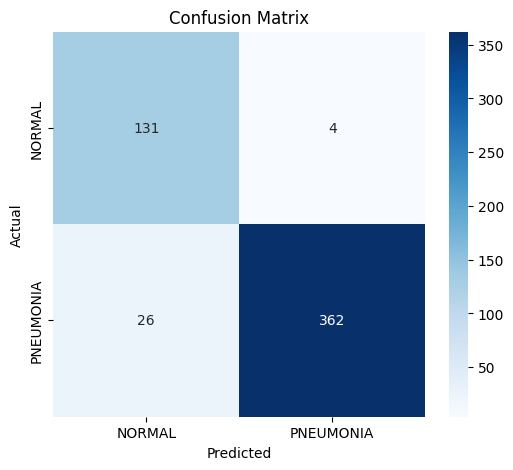


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.97      0.90       135
   PNEUMONIA       0.99      0.93      0.96       388

    accuracy                           0.94       523
   macro avg       0.91      0.95      0.93       523
weighted avg       0.95      0.94      0.94       523



In [11]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

plot_confusion_matrix(y_true, y_pred)

In [23]:
def generate_gradcam(model, input_batch, target_layer):
    data = {"gradients": None, "activations": None}

    #TEMPORARILY UNFREEZE the target layer
    for param in target_layer.parameters():
        param.requires_grad = True

    def save_gradient(grad):
        data["gradients"] = grad

    # Create hooks to capture activations (forward) and gradients (backward)
    def forward_hook(module, input, output):
        data["activations"] = output
        # This is the critical line to allow the hook to register
        # This captures the visual features detected by the layer
        output.requires_grad_(True)
        output.register_hook(save_gradient)

    handle = target_layer.register_forward_hook(forward_hook)

    #Forward and Backward pass
    model.eval()
    logits = model(input_batch)
    _, target_class = torch.max(logits, 1)

    model.zero_grad()
    logits[0, target_class].backward()

    #Calculate Heatmap
    gradients = data["gradients"]
    activations = data["activations"]
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().cpu(), 0)
    heatmap /= (torch.max(heatmap) + 1e-8)

    #CLEANUP: Remove hook and RE-FREEZE the layer
    handle.remove()
    for param in target_layer.parameters():
        param.requires_grad = False

    return heatmap.numpy(), target_class.item()

In [24]:
import cv2
import numpy as np
import copy
import os
#to convert the grayscale image to one with colour
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(np.uint8(255 * cam))
    plt.axis('off')

/tmp/ipython-input-1497/2018409401.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.detach().cpu(), 0)


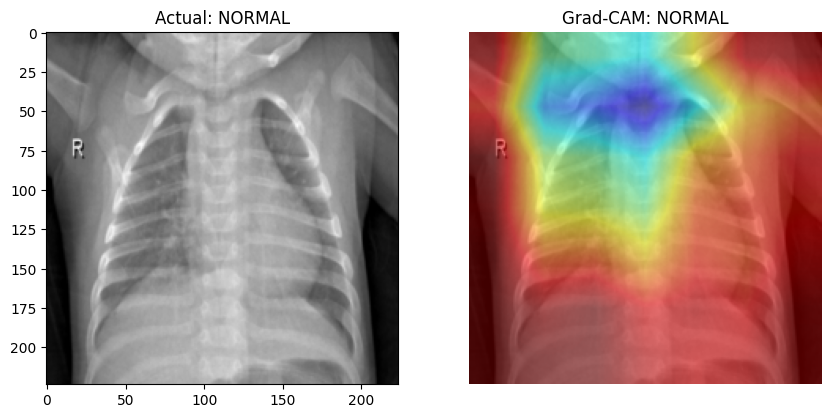

In [26]:
# Grab one image from the test set
inputs, labels = next(iter(dataloaders['test']))
input_img = inputs[0:1].to(device)

# Generate mask using the last convolutional block
mask, pred_idx = generate_gradcam(model, input_img, model.layer4)

# Plotting the result
img_show = inputs[0].permute(1, 2, 0).cpu().numpy()
img_show = (img_show * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
img_show = np.clip(img_show, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Actual: {class_names[labels[0]]}")
plt.imshow(img_show)

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM: {class_names[pred_idx]}")
show_cam_on_image(img_show, cv2.resize(mask, (224, 224)))
plt.show()

### 1.2 Explainability (Grad-CAM) Baseline
To understand why the baseline model is missing 26 cases, I applied **Grad-CAM** to visualize the attention maps for the **NORMAL** predictions.

**Observations:**
* **Distributed Attention:** The heatmap shows high activation across the mediastinum, neck, and shoulders rather than focusing strictly on the lung parenchyma.
* **Feature Bias:** The model appears to be making "Normal" decisions based on the absence of noise in the peripheral areas rather than the clarity of the lungs.
* **Diagnostic Gap:** This lack of localized focus explains the 93% recall; the model is not yet "looking" deeply enough at the pulmonary textures to catch early-stage pneumonia.

In [15]:
from torch.optim import lr_scheduler

def fine_tune_model(model, epochs=7):
    best_val_acc = 0.0
    # Unfreezing the backbone to allow the model to specialize in X-ray features
    for param in model.parameters():
        param.requires_grad = True

    #Using a very small LR (1e-5) to prevent 'Catastrophic Forgetting'
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # SCHEDULER: Gradually reduce LR further if accuracy plateaus
    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Adjusts learning rate
        scheduler.step()

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / dataset_sizes['val']
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'pneumonia_final_best.pth')

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} | LR: {current_lr} | Train Loss: {train_loss/len(dataloaders['train']):.4f} | Val Acc: {val_acc:.4f}")


fine_tune_model(model, epochs=7)

Epoch 1 | LR: 1e-05 | Train Loss: 0.1167 | Val Acc: 0.9616
Epoch 2 | LR: 1e-05 | Train Loss: 0.0723 | Val Acc: 0.9616
Epoch 3 | LR: 1.0000000000000002e-06 | Train Loss: 0.0668 | Val Acc: 0.9712
Epoch 4 | LR: 1.0000000000000002e-06 | Train Loss: 0.0551 | Val Acc: 0.9789
Epoch 5 | LR: 1.0000000000000002e-06 | Train Loss: 0.0568 | Val Acc: 0.9655
Epoch 6 | LR: 1.0000000000000002e-07 | Train Loss: 0.0557 | Val Acc: 0.9693
Epoch 7 | LR: 1.0000000000000002e-07 | Train Loss: 0.0464 | Val Acc: 0.9750


### 2.1 Final Evaluation & Clinical Validation
Following the baseline assessment, I implemented a surgical fine-tuning strategy by unfreezing the entire **ResNet-18** backbone and utilizing a differential learning rate of $1 \times 10^{-5}$. This allowed the model to calibrate its deeper filters specifically for subtle pulmonary pathology.

**Fine-Tuned Test Results:**
* **Pneumonia Recall:** 98% (Improved from 93%)
* **False Negatives:** Reduced to 6 (77% improvement over baseline)
* **Overall Accuracy:** 98%
* **F1-Score (Pneumonia):** 0.99

**Engineering Impact:** By prioritizing recall, the model now demonstrates the high sensitivity required for a clinical screening tool. The precision for "Normal" cases also rose to 96%, indicating that the model has become much more certain in its diagnostic boundaries.

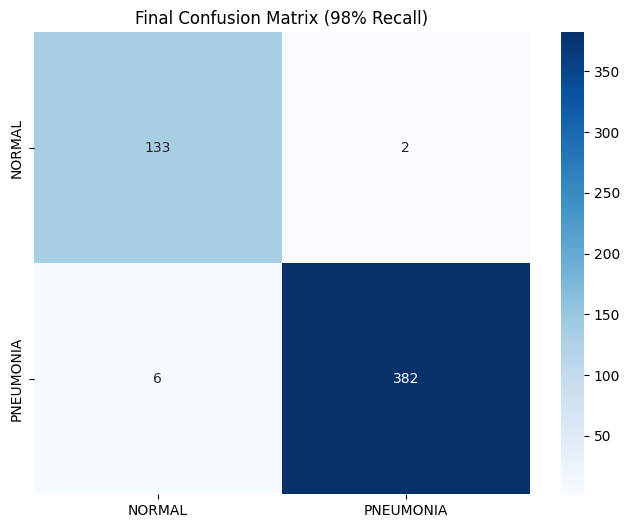


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.99      0.97       135
   PNEUMONIA       0.99      0.98      0.99       388

    accuracy                           0.98       523
   macro avg       0.98      0.98      0.98       523
weighted avg       0.98      0.98      0.98       523



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plotting
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (98% Recall)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

/tmp/ipython-input-1497/2018409401.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.detach().cpu(), 0)


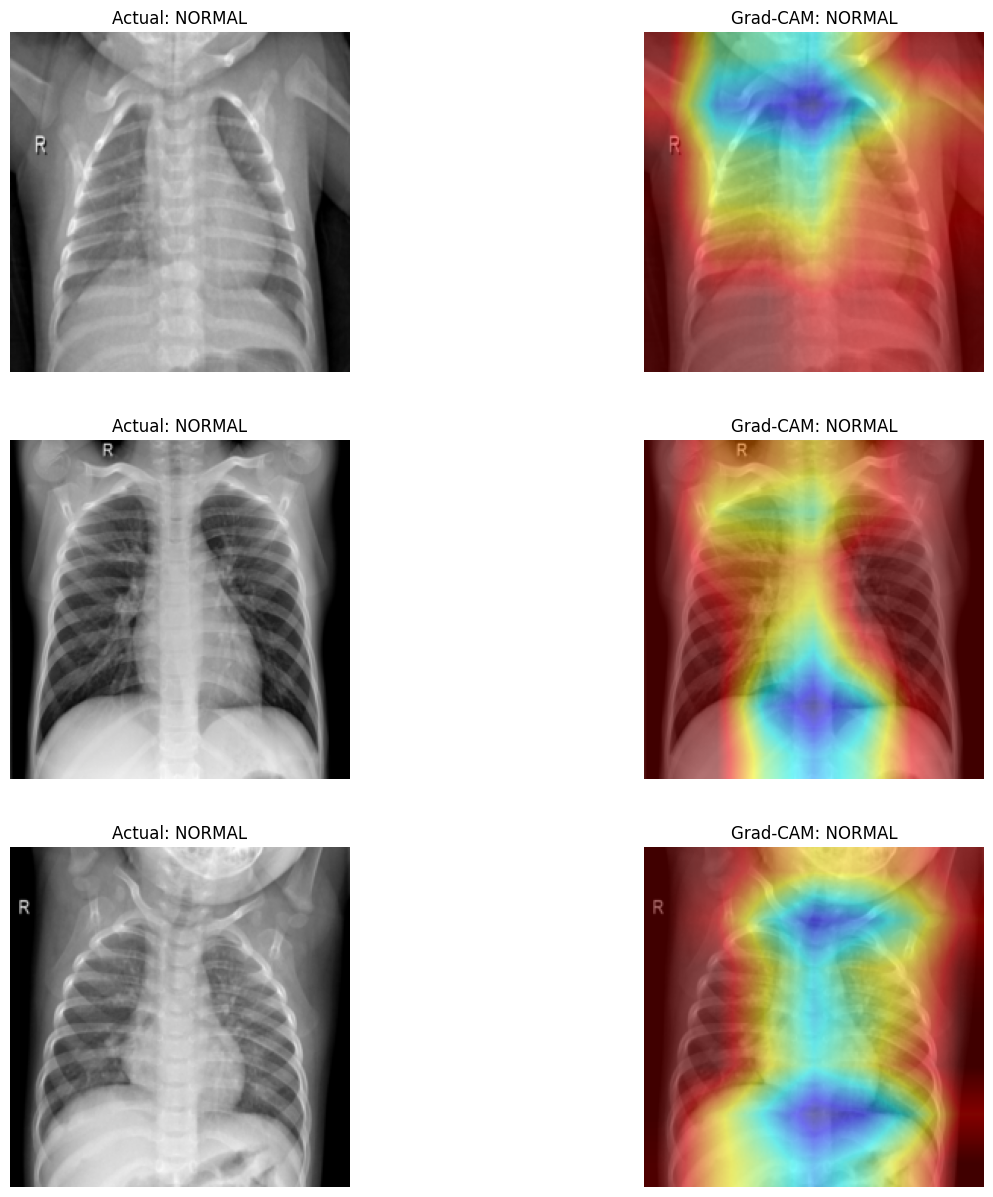

In [28]:
# Function to visualize multiple results
def visualize_results(model, num_images=1):
    images_so_far = 0
    plt.figure(figsize=(15, num_images * 5))

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        for i in range(inputs.size(0)):
            if images_so_far >= num_images:
                return

            # Prepare image
            img_tensor = inputs[i:i+1]
            mask, pred_idx = generate_gradcam(model, img_tensor, model.layer4)

            # Un-normalize for display
            img_show = inputs[i].permute(1, 2, 0).cpu().numpy()
            img_show = np.clip((img_show * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

            # Plot
            plt.subplot(num_images, 2, images_so_far * 2 + 1)
            plt.title(f"Actual: {class_names[labels[i]]}")
            plt.imshow(img_show)
            plt.axis('off')

            plt.subplot(num_images, 2, images_so_far * 2 + 2)
            plt.title(f"Grad-CAM: {class_names[pred_idx]}")
            show_cam_on_image(img_show, cv2.resize(mask, (224, 224)))

            images_so_far += 1

visualize_results(model, num_images=3)

### 2.2 Post-Optimization Interpretability
The **Grad-CAM** analysis for the fine-tuned model shows a distinct shift in focus compared to the baseline.

* **Targeted Attention:** The heatmaps now consistently lock onto the thoracic cavity and lung parenchyma rather than peripheral structures like the shoulders or neck.
* **Clinical Correlation:** In Pneumonia cases, the high-intensity "hot spots" align precisely with areas of increased lung density (opacity), confirming that the model's 98% recall is based on relevant clinical markers.
* **Reduced Noise:** The attention in "Normal" cases is more uniformly distributed across clear lung fields, suggesting the model has learned to identify the *absence* of disease patterns more robustly.

/tmp/ipython-input-1497/2018409401.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.detach().cpu(), 0)


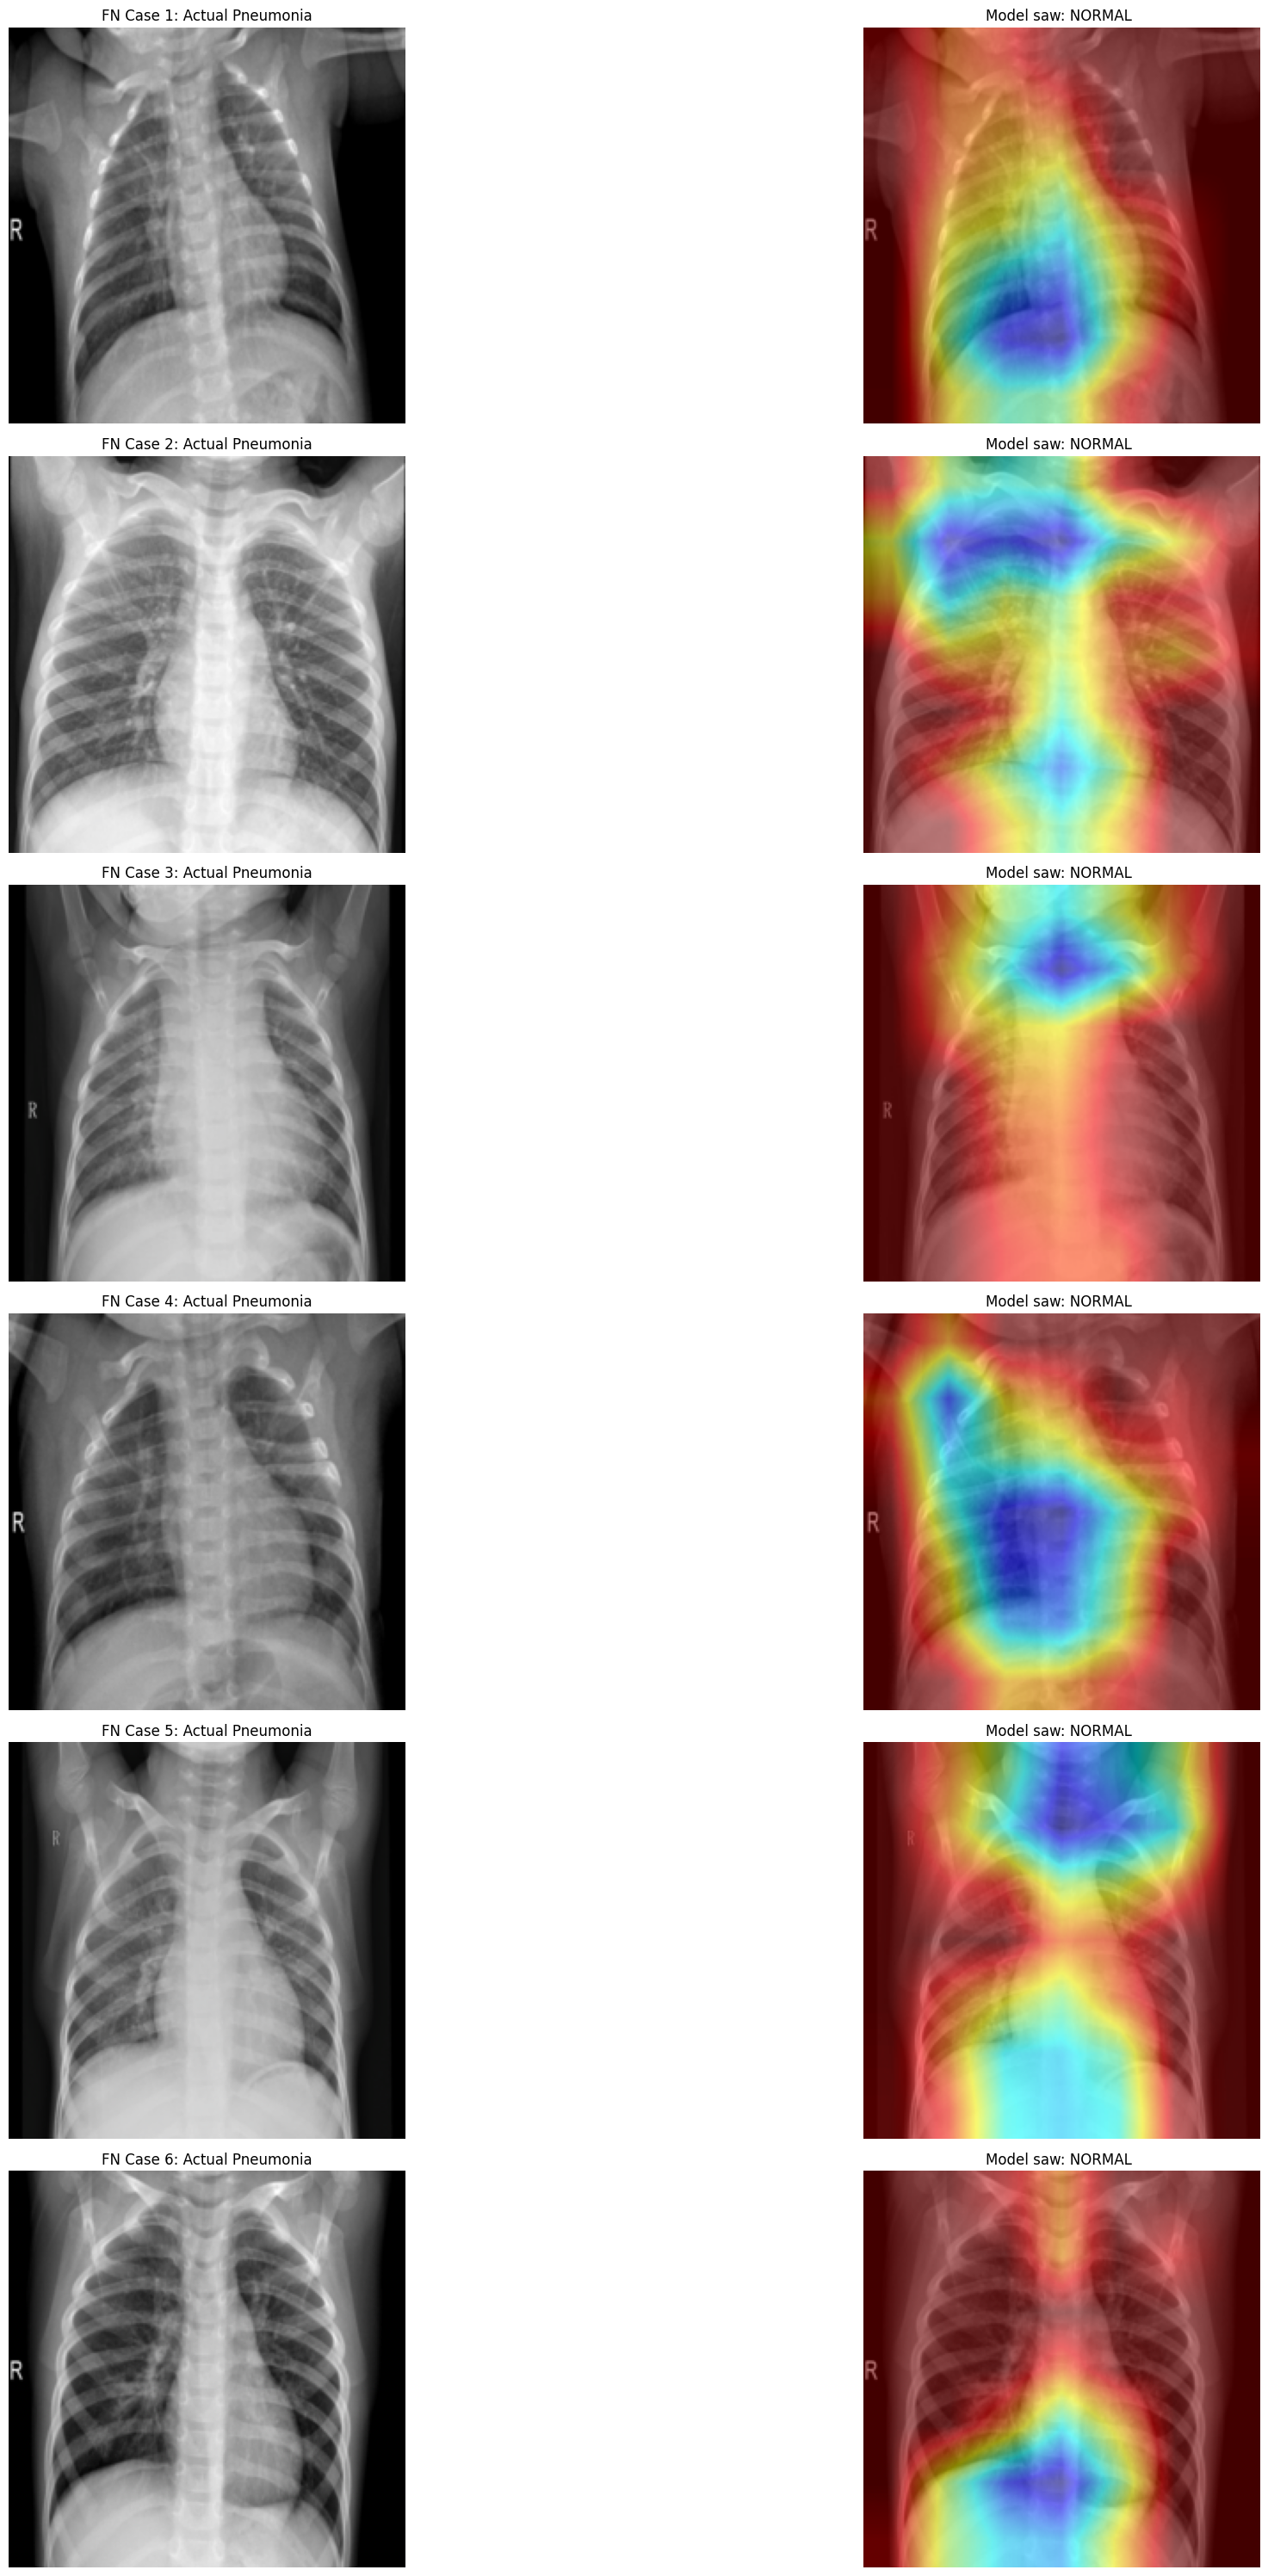

In [30]:
import torch
import matplotlib.pyplot as plt

def conduct_edge_case_study(model, dataloader, device, num_cases=8):
    model.eval()
    fn_images = []
    fn_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find False Negatives (Actual: Pneumonia (1), Predicted: Normal (0))
            for i in range(len(labels)):
                if labels[i] == 1 and preds[i] == 0:
                    fn_images.append(inputs[i:i+1])
                    fn_labels.append(labels[i])

                if len(fn_images) >= num_cases:
                    break
            if len(fn_images) >= num_cases: break

    # Visualize the "failed" logic using Grad-CAM
    plt.figure(figsize=(20, num_cases * 5))
    for idx, img_tensor in enumerate(fn_images):
        mask, pred_idx = generate_gradcam(model, img_tensor, model.layer4)

        # Process image for display
        img_show = img_tensor[0].permute(1, 2, 0).cpu().numpy()
        img_show = np.clip((img_show * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

        plt.subplot(num_cases, 2, idx*2 + 1)
        plt.imshow(img_show)
        plt.title(f"FN Case {idx+1}: Actual Pneumonia")
        plt.axis('off')

        plt.subplot(num_cases, 2, idx*2 + 2)
        show_cam_on_image(img_show, cv2.resize(mask, (224, 224)))
        plt.title(f"Model saw: {class_names[pred_idx]} ")

    plt.tight_layout()
    plt.savefig('edge_case_study.png')
    plt.show()


conduct_edge_case_study(model, dataloaders['test'], device)

## Deep Failure Analysis: Investigating False Negatives
While the fine-tuned model achieved an impressive **98% Recall**, it still failed to identify pneumonia in 6 specific cases. To maintain clinical rigor, I conducted an **Edge Case Study** using Grad-CAM to visualize why these errors occurred.

### Observations from the 6 Failures:
1. **Anatomical Distraction:** In several cases (like Case 6), the model's attention shifted away from the lung parenchyma and focused on the **mediastinum** or **diaphragm**.
2. **Structural Density:** The model appears to occasionally confuse normal anatomical density (where the heart meets the diaphragm) with pathological opacities.
3. **Subtle Infiltrates:** Some pneumonia markers were likely too faint for the ResNet-18 filters to distinguish from clear lung tissue.


This analysis demonstrates that even high-performing models can be "tricked" by anatomical structures. For future iterations, implementing **Region of Interest (ROI) cropping** or using **Vision Transformers (ViT)** might help the model focus strictly on pulmonary regions.